# Predicting Clicks on Ads and Understanding Variables to Improve Click Rates

## Goal

The goal of this project is to utilize machine learning tools to predict clicks on future ads and determine what factors influence clicks.

## The Dataset

Dataset used is obtained from Kaggle, uploaded by Gopal Chettri, linked here: https://www.kaggle.com/datasets/gopalchettri/advertisement

This data set contains the following features:
- 'Daily Time Spent on Site': consumer time on site in minutes
- 'Age': customer age in years
- 'Area Income': average income of geographical area of consumer, assumed in US dollars
- 'Daily Internet Usage': average minutes a day consumer is on the internet
- 'Ad Topic Line': headline of the advertisement
- 'City': city location of consumer
- 'Male': whether or not consumer is male
- 'Country': country location of consumer
- 'Timestamp': time at which consumer clicked on ad or closed window
- 'Clicked on Ad': whether or not consumer clicked on ad

In [1]:
import pandas as pd
df = pd.read_csv('advertising.csv')

In [2]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [3]:
print(df.shape)

(1000, 10)


There are 1000 rows and 10 columns.

Since the city locations might be too granular for us to consider, we can drop the City column.

In [4]:
df = df.drop(['City'], axis = 1)

### Cleaning and Examining the Dataset

We can check for NaN values and duplicate rows.

In [5]:
# check NaN values
print('Number of NaN values:')
print(pd.isna(df).sum(axis = 0))

# check duplicates
print('Number of duplicate rows:', sum(df.duplicated()))

Number of NaN values:
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64
Number of duplicate rows: 0


We can further look at the ranges of each variable.

In [6]:
# range of daily time on site
print('Range of Daily Time on Site (minutes):', min(df['Daily Time Spent on Site']), ' to ',
      max(df['Daily Time Spent on Site']))

# age range of consumer
print('Consumer Age Range: ', min(df['Age']), ' to ', max(df['Age']))

# range of area income
print('Area Income Range (US$): ', min(df['Area Income']), ' to ', max(df['Area Income']))

# range of internet usage
print('Range of Daily Internet Usage (minutes): ', min(df['Daily Internet Usage']), ' to ', max(df['Daily Internet Usage']))

# number of distinct ad topic lines
print('Number of distinct Ad Topic Lines in dataset: ', len(set(df['Ad Topic Line'])))

# male ratio
print('Fraction of Males in dataset: ', sum(df['Male']) / len(df))

# number of countries
print('Number of Countries in dataset: ', len(set(df['Country'])))

# timeframe of data
print('Timeframe of data: ', min(df['Timestamp']), ' to ', max(df['Timestamp']))

# check ratio of people who clicked on dataset
print('Fraction of people who Clicked on Ad: ', sum(df['Clicked on Ad']) / len(df))

Range of Daily Time on Site (minutes): 32.6  to  91.43
Consumer Age Range:  19  to  61
Area Income Range (US$):  13996.5  to  79484.8
Range of Daily Internet Usage (minutes):  104.78  to  269.96
Number of distinct Ad Topic Lines in dataset:  1000
Fraction of Males in dataset:  0.481
Number of Countries in dataset:  237
Timeframe of data:  2016-01-01 02:52:10  to  2016-07-24 00:22:16
Fraction of people who Clicked on Ad:  0.5


### Splitting Timestamp Column

We can split the Timestamp column to Month, Weekday, and Hour. Since the data only ranges from Jan 2016 to July 2016, there is no need to consider Year. Also, Minute and Second are too granular, so we can leave those out as well.

In [7]:
type(df['Timestamp'][0])

str

The Timestamp column currently has data of type `str`. Then we need to use the `datetime` module to extract relevant information.

In [8]:
import datetime

def change_datetime(strdate):
    dt_tuple = tuple([int(x) for x in strdate[:10].split('-')]) + tuple([int(x) for x in strdate[11:].split(':')])
    return datetime.datetime(*dt_tuple)

In [9]:
# example

strdate = '2017-01-02 03:12:34'
change_datetime(strdate)

datetime.datetime(2017, 1, 2, 3, 12, 34)

We can now convert the Timestamp column data to `datetime` and add new columns for Month, Weekday, and Hour.

In [10]:
df['Timestamp'] = df['Timestamp'].apply(change_datetime)
df['Month'] = df['Timestamp'].apply(lambda x: x.month)
df['Weekday'] = df['Timestamp'].apply(lambda x: x.weekday())
df['Hour'] = df['Timestamp'].apply(lambda x: x.hour)

Since Timestamp is not needed anymore, we can simply drop that column.

In [11]:
df = df.drop('Timestamp', axis = 1)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Country,Clicked on Ad,Month,Weekday,Hour
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,Tunisia,0,3,6,0
1,80.23,31,68441.85,193.77,Monitored national standardization,1,Nauru,0,4,0,1
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,San Marino,0,3,6,20
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,Italy,0,1,6,2
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,Iceland,0,6,4,3


### Add Continent Column

We can attempt to add a Continent variable and observe if the continent location influences clicks or not.

In [12]:
import pycountry_convert as pc

def country_to_continent(country_name):
    try: 
        country_code = pc.country_name_to_country_alpha2(country_name, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continents = {
        'NA': 'North America',
        'SA': 'South America', 
        'AS': 'Asia',
        'OC': 'Oceania',
        'AF': 'Africa',
        'EU': 'Europe'}
        return continents[continent_code]
    except:
        return ''

In [13]:
df['Continent'] = df['Country'].apply(country_to_continent)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Country,Clicked on Ad,Month,Weekday,Hour,Continent
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,Tunisia,0,3,6,0,Africa
1,80.23,31,68441.85,193.77,Monitored national standardization,1,Nauru,0,4,0,1,Oceania
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,San Marino,0,3,6,20,Europe
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,Italy,0,1,6,2,Europe
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,Iceland,0,6,4,3,Europe


Some of the Continent column data is empty because the country is not listed in the module. Then we can try to add them manually. We can split the dataframe into one with filled Continent data and one without. We can add the Continent variable manually to the one without and finally, concatenate the two dataframes together.

In [14]:
# split into with listed continent and non-listed continent

df_withcontinent = df[df['Continent'] != '']
df_withoutcontinent = df[df['Continent'] == '']

In [15]:
# check countries with no code in package

set(df_withoutcontinent['Country'])

{'Antarctica (the territory South of 60 deg S)',
 'Bouvet Island (Bouvetoya)',
 'British Indian Ocean Territory (Chagos Archipelago)',
 "Cote d'Ivoire",
 'French Southern Territories',
 'Heard Island and McDonald Islands',
 'Holy See (Vatican City State)',
 'Korea',
 'Libyan Arab Jamahiriya',
 'Netherlands Antilles',
 'Palestinian Territory',
 'Pitcairn Islands',
 'Reunion',
 'Saint Barthelemy',
 'Saint Helena',
 'Slovakia (Slovak Republic)',
 'Svalbard & Jan Mayen Islands',
 'Timor-Leste',
 'United States Minor Outlying Islands',
 'Western Sahara'}

In [16]:
def add_continent(country_name):
    continents = {'Antarctica (the territory South of 60 deg S)': 'Antartica',
     'Bouvet Island (Bouvetoya)': 'Antartica',
     'British Indian Ocean Territory (Chagos Archipelago)': 'Asia',
     "Cote d'Ivoire": 'Africa',
     'French Southern Territories': 'Europe',
     'Heard Island and McDonald Islands': 'Antartica',
     'Holy See (Vatican City State)': 'Europe',
     'Korea': 'Asia',
     'Libyan Arab Jamahiriya': 'Africa',
     'Netherlands Antilles': 'North America',
     'Palestinian Territory': 'Asia',
     'Pitcairn Islands': 'Oceania',
     'Reunion': 'Europe',
     'Saint Barthelemy': 'North America',
     'Saint Helena': 'Africa',
     'Slovakia (Slovak Republic)': 'Europe',
     'Svalbard & Jan Mayen Islands': 'Europe',
     'Timor-Leste': 'Asia',
     'United States Minor Outlying Islands': 'North America',
     'Western Sahara': 'Africa'}
    return continents[country_name]

# the information for the continents are obtained from various online
# sources such as Wikipedia

In [17]:
df_withoutcontinent['Continent'] = df_withoutcontinent['Country'].apply(add_continent)

C:\Users\tracy\AppData\Local\Temp/ipykernel_13492/1889801857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_withoutcontinent['Continent'] = df_withoutcontinent['Country'].apply(add_continent)


In [18]:
# check the non-listed part has continent

df_withoutcontinent.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Country,Clicked on Ad,Month,Weekday,Hour,Continent
16,55.39,37,23936.86,129.41,Customizable multi-tasking website,0,Palestinian Territory,1,1,5,19,Asia
18,54.70,36,31087.54,118.39,Grass-roots solution-oriented conglomeration,1,British Indian Ocean Territory (Chagos Archipe...,1,2,5,7,Asia
23,87.29,36,61628.72,209.93,Future-proofed methodical protocol,1,Korea,0,3,2,9,Asia
29,76.02,22,46179.97,209.82,Business-focused value-added definition,0,Bouvet Island (Bouvetoya),0,1,2,12,Antartica
38,50.43,46,57425.87,119.32,Persevering needs-based open architecture,1,Saint Helena,1,5,5,17,Africa


In [19]:
# combine to make big df with complete continents

df = pd.concat([df_withcontinent, df_withoutcontinent], axis = 0)
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,Male,Country,Clicked on Ad,Month,Weekday,Hour,Continent
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,0,Tunisia,0,3,6,0,Africa
1,80.23,31,68441.85,193.77,Monitored national standardization,1,Nauru,0,4,0,1,Oceania
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,0,San Marino,0,3,6,20,Europe
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,1,Italy,0,1,6,2,Europe
4,68.37,35,73889.99,225.58,Robust logistical utilization,0,Iceland,0,6,4,3,Europe


In [20]:
# check that none of the Continent entries are empty

sum(df['Continent'] == '')

0

### Finalize Dataset that We Want

Now we have all the variables we want, so we can rearrange the columns to understand it better.

In [21]:
df = df[['Ad Topic Line', 'Month', 'Weekday', 'Hour', 'Daily Time Spent on Site', 'Daily Internet Usage', 'Male', 'Age', 'Area Income', 
        'Country', 'Continent', 'Clicked on Ad']]
df.head()

,Ad Topic Line,Month,Weekday,Hour,Daily Time Spent on Site,Daily Internet Usage,Male,Age,Area Income,Country,Continent,Clicked on Ad
0,Cloned 5thgeneration orchestration,3,6,0,68.95,256.09,0,35,61833.90,Tunisia,Africa,0
1,Monitored national standardization,4,0,1,80.23,193.77,1,31,68441.85,Nauru,Oceania,0
2,Organic bottom-line service-desk,3,6,20,69.47,236.50,0,26,59785.94,San Marino,Europe,0
3,Triple-buffered reciprocal time-frame,1,6,2,74.15,245.89,1,29,54806.18,Italy,Europe,0
4,Robust logistical utilization,6,4,3,68.37,225.58,0,35,73889.99,Iceland,Europe,0


## Model Prediction of Clicks

Firstly, we want to label encode the categorical data so machine learning models understand it. We can create a copy dataframe in case we want to go back to the original one and manipulate the original data.

In [22]:
df1 = df.copy()

# label encode categorical data

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df1['Ad Topic Line'] = le.fit_transform(df1['Ad Topic Line'])
df1['Month'] = le.fit_transform(df1['Month'])
df1['Hour'] = le.fit_transform(df1['Hour'])
df1['Country'] = le.fit_transform(df1['Country'])
df1['Continent'] = le.fit_transform(df1['Continent'])

In [23]:
df1.head()

,Ad Topic Line,Month,Weekday,Hour,Daily Time Spent on Site,Daily Internet Usage,Male,Age,Area Income,Country,Continent,Clicked on Ad
0,91,2,6,0,68.95,256.09,0,35,61833.90,215,0,0
1,464,3,0,1,80.23,193.77,1,31,68441.85,147,5,0
2,566,2,6,20,69.47,236.50,0,26,59785.94,184,3,0
3,903,0,6,2,74.15,245.89,1,29,54806.18,103,3,0
4,766,5,4,3,68.37,225.58,0,35,73889.99,96,3,0


### Correlation Matrix

We can now try to plot a correlation Matrix between variables.

<function matplotlib.pyplot.show(close=None, block=None)>

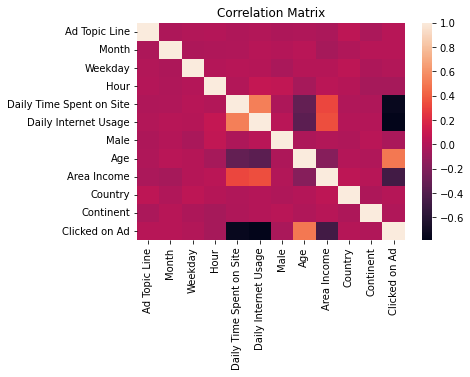

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.heatmap(df1.corr())
plt.title('Correlation Matrix')
plt.show

Interestingly, for the Clicked on Ad variable, there appears to be negative correlations with Daily Time Spent on Site, Daily Internet Usage, and Area Income. There appears to be a positive correlation with Age. We can investigate this further after implementing the model.

We can now split the data into features and target, then into train and test data.

In [25]:
# split df into features and target

X = df1.loc[:, 'Ad Topic Line':'Continent']
y = df1['Clicked on Ad']

# split into train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

### K-Nearest Neighbors Algorithm

In using the K-Nearest Neighbors Algorithm in this project, we can focus on tuning the optimal number of neighbors to use, i.e. the hyperparameter `n_neighbors`. We can use basic cross validation to select the optimal number.

In [26]:
# perform cross validation to select optimal k

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

neighbors = []
cv_scores = []

# choose a number k from 1 to 30
for k in range(1, 31):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, scoring = 'accuracy')
    cv_scores.append(scores.mean())

scores = cross_val_score(knn, X, y, scoring = 'accuracy')
scores

array([0.755, 0.65 , 0.72 , 0.705, 0.72 ])

In [27]:
# plot misclassification errors

MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
optimal_k

29

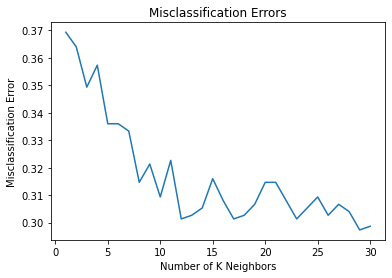

In [28]:
plt.figure()
plt.plot(neighbors, MSE)
plt.xlabel('Number of K Neighbors')
plt.ylabel('Misclassification Error')
plt.title('Misclassification Errors')
plt.show()

It seems that the model with the lowest Misclassification Error is indeed the one with 29 neighbors.

In [29]:
knn = KNeighborsClassifier(n_neighbors = 29)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 0], dtype=int64)

We can check the accuracy score.

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.732

This is a low accuracy score. A good model has an accuracy score of at least 90. We can plot the accuracy scores of the values of k to see if the accuracy scores increase at some point.

<function matplotlib.pyplot.show(close=None, block=None)>

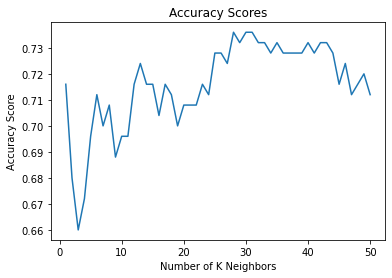

In [31]:
# plot accuracy scores to see

neighbors = []
accuracy_scores = []

for k in range(1, 51):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
plt.figure()
plt.plot(neighbors, accuracy_scores)
plt.xlabel('Number of K Neighbors')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores')
plt.show

Since the accuracy score is still low until `k = 50`, this suggests that we might have to choose a different model.

### Random Forest

For this project, the hyperparameter we will look at is the number of estimators, i.e. n_estimators.

In [32]:
from sklearn.ensemble import RandomForestClassifier

# choose 100 estimators

rf = RandomForestClassifier(n_estimators = 100) 
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1], dtype=int64)

Let's check the accuracy score.

In [33]:
accuracy_score(y_test, y_pred)

0.96

Since the accuracy score is high, we can simply use this hyperparameter. We can also plot the accuracy scores to see if there is significant improvements we can make by choosing different values of n_estimators. 

<function matplotlib.pyplot.show(close=None, block=None)>

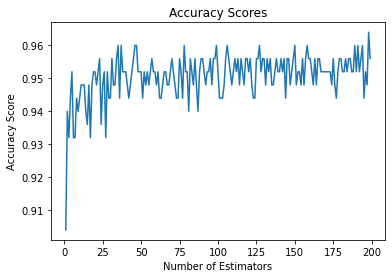

In [34]:
# plot accuracy scores to see

estimators = []
accuracy_scores = []

for e in range(1, 200):
    estimators.append(e)
    rf = RandomForestClassifier(n_estimators = e)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
plt.figure()
plt.plot(estimators, accuracy_scores)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores')
plt.show

Since there is not much improvements, we can just stick to this model and number of estimators.

**Note:** We can further tune the other hyperparameters of this model to increase the accuracy scores and provide more accurate predictions, but for the sake of simplicity we can just use the model as is.

We can create a confusion matrix of the model and look at feature importances.

In [35]:
# create the confusion matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[120,   6],
       [  5, 119]], dtype=int64)

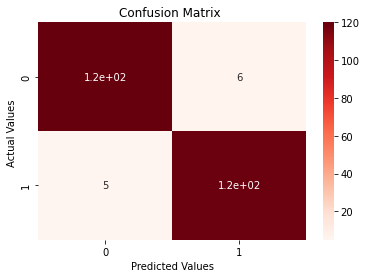

In [36]:
ax = sns.heatmap(cm, annot = True, cmap='Reds')

ax.set_title('Confusion Matrix ');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_ticklabels([0, 1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [37]:
# look at feature impor

feature_imp = pd.Series(rf.feature_importances_, index = df1.columns[:-1:])
feature_imp

Ad Topic Line               0.018647
Month                       0.009147
Weekday                     0.007758
Hour                        0.013038
Daily Time Spent on Site    0.304210
Daily Internet Usage        0.424202
Male                        0.003017
Age                         0.091341
Area Income                 0.102469
Country                     0.017306
Continent                   0.008866
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

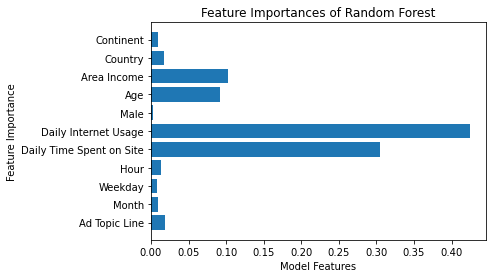

In [38]:
plt.figure()
plt.barh(list(feature_imp.index), list(feature_imp))
plt.xlabel('Model Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances of Random Forest')
plt.show

The plot shows that Daily Internet Usage and Daily Time Spent on Site have high importance, and Age and Area Income have relatively higher importance. This confirms our hypothesis from the correlation heatmap.

We can now map out the click rates based on these variables.

## Click Rates by Variables

### Click Rate by Daily Time Spent on Site

<function matplotlib.pyplot.show(close=None, block=None)>

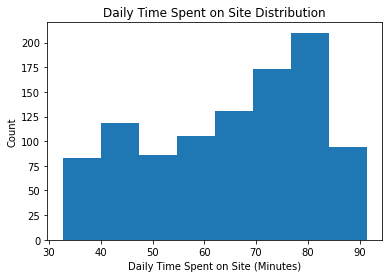

In [39]:
# map out distribution of Daily Time

plt.figure()
plt.hist(df['Daily Time Spent on Site'], bins = 8)
plt.title('Daily Time Spent on Site Distribution')
plt.xlabel('Daily Time Spent on Site (Minutes)')
plt.ylabel('Count')
plt.show

In [40]:
# click rate groupby bins

clickrate_dailytime = df.groupby(pd.cut(df['Daily Time Spent on Site'], bins = 8))['Clicked on Ad'].mean()
clickrate_dailytime

Daily Time Spent on Site
(32.541, 39.954]    1.000000
(39.954, 47.308]    1.000000
(47.308, 54.661]    0.953488
(54.661, 62.015]    0.857143
(62.015, 69.369]    0.519084
(69.369, 76.722]    0.184971
(76.722, 84.076]    0.090476
(84.076, 91.43]     0.085106
Name: Clicked on Ad, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

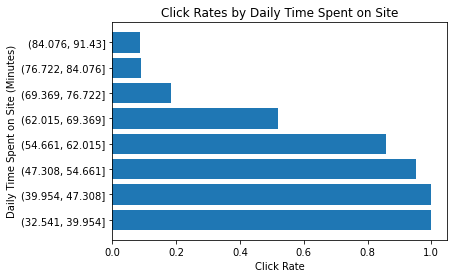

In [41]:
plt.figure()
plt.barh((clickrate_dailytime.index).astype(str), list(clickrate_dailytime))
plt.title('Click Rates by Daily Time Spent on Site')
plt.xlabel('Click Rate')
plt.ylabel('Daily Time Spent on Site (Minutes)')
plt.show

We see that people with Daily Time Spent on Site <= approx. 62 minutes tend to have a mean click rate higher than 0.8.

### Click Rate by Daily Internet Usage

<function matplotlib.pyplot.show(close=None, block=None)>

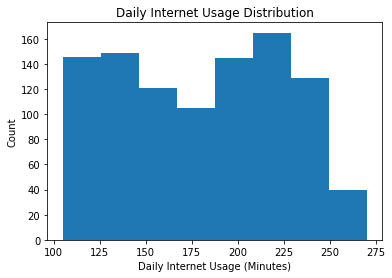

In [42]:
# map out distribution of Daily Internet Usage

plt.figure()
plt.hist(df['Daily Internet Usage'], bins = 8)
plt.title('Daily Internet Usage Distribution')
plt.xlabel('Daily Internet Usage (Minutes)')
plt.ylabel('Count')
plt.show

In [43]:
# click rate 

clickrate_dailyinternet = df.groupby(pd.cut(df['Daily Internet Usage'], bins = 8))['Clicked on Ad'].mean()
clickrate_dailyinternet

Daily Internet Usage
(104.615, 125.428]    1.000000
(125.428, 146.075]    1.000000
(146.075, 166.722]    0.842975
(166.722, 187.37]     0.523810
(187.37, 208.017]     0.186207
(208.017, 228.665]    0.060606
(228.665, 249.312]    0.038760
(249.312, 269.96]     0.150000
Name: Clicked on Ad, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

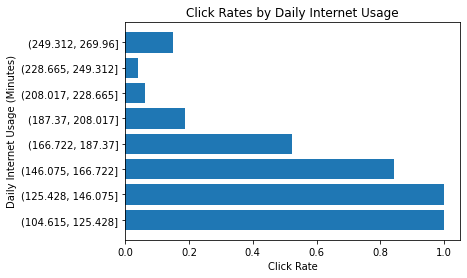

In [44]:
plt.figure()
plt.barh((clickrate_dailyinternet.index).astype(str), list(clickrate_dailyinternet))
plt.title('Click Rates by Daily Internet Usage')
plt.xlabel('Click Rate')
plt.ylabel('Daily Internet Usage (Minutes)')
plt.show

We see that people with Daily Internet Usage <= approx. 167 minutes tend to have a mean click rate higher than 0.8.

### Click Rate by Area Income

<function matplotlib.pyplot.show(close=None, block=None)>

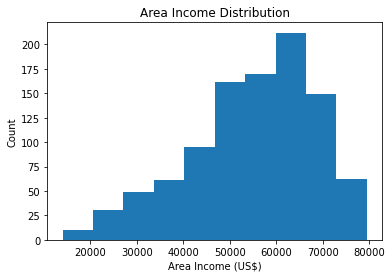

In [45]:
# map out distribution of Area Income
plt.figure()
plt.hist(df['Area Income'])
plt.title('Area Income Distribution')
plt.xlabel('Area Income (US$)')
plt.ylabel('Count')
plt.show

In [46]:
# click rate groupby bins

clickrate_areaincome = df.groupby(pd.cut(df['Area Income'], bins = 10))['Clicked on Ad'].mean()
clickrate_areaincome

Area Income
(13931.012, 20545.33]    1.000000
(20545.33, 27094.16]     1.000000
(27094.16, 33642.99]     0.959184
(33642.99, 40191.82]     0.868852
(40191.82, 46740.65]     0.747368
(46740.65, 53289.48]     0.611111
(53289.48, 59838.31]     0.435294
(59838.31, 66387.14]     0.283019
(66387.14, 72935.97]     0.268456
(72935.97, 79484.8]      0.258065
Name: Clicked on Ad, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

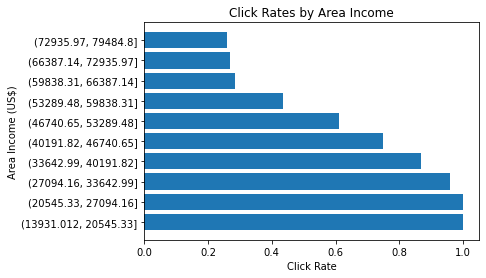

In [47]:
plt.figure()
plt.barh((clickrate_areaincome.index).astype(str), list(clickrate_areaincome))
plt.title('Click Rates by Area Income')
plt.xlabel('Click Rate')
plt.ylabel('Area Income (US$)')
plt.show

We see that people with Area Income <= approx. 40.2K tend to have a mean click rate higher than 0.8.

### Click Rate by Age

In [48]:
# split by age ranges: 19-29, 30-39, 40-49, 50-61

age_ranges = ['19-29', '30-39', '40-49', '50-61']

click_rate = []

for s in age_ranges:
    df_age = df[(df['Age'] >= int(s[0:2])) & (df['Age'] <= int(s[3:]))]
    click_rate_age = sum(df_age['Clicked on Ad']) / len(df_age)
    click_rate.append(click_rate_age)

click_rate

[0.24621212121212122,
 0.41119221411192214,
 0.7639484978540773,
 0.9565217391304348]

<function matplotlib.pyplot.show(close=None, block=None)>

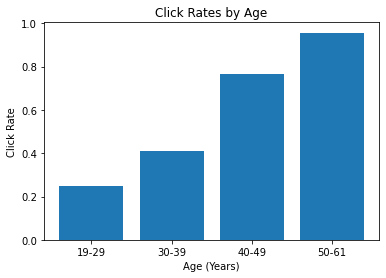

In [49]:
plt.figure()
plt.bar(age_ranges, click_rate)
plt.title('Click Rates by Age')
plt.ylabel('Click Rate')
plt.xlabel('Age (Years)')
plt.show

We see that people with Age >= 40 tend to have a mean click rate of approx. 80.

## Conclusion

From the analysis of these four variables, we can say that the people who are most likely to click on the ad are those with:
- Low Daily Time Spent on Site (<= ~62 minutes)
- Low Daily Internet Usage (<= ~167 minutes)
- Low Area Income (<= ~40.2K)
- High Age (>= 40 years)

Using a Random Forest model with 100 estimators, we are able to obtain an accuracy score of >= 95%